## Install Modules

In [3]:
%pip install librosa
%pip install -U ipykernel
%pip install noisereduce
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   -------------------------------------- - 286.7/294.6 kB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
from glob import glob
import librosa
import warnings
import seaborn as sns
import random
import IPython.display as ipd
import matplotlib.pyplot as plt 
import noisereduce as nr
warnings.filterwarnings("ignore")

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Files

In [3]:
tqdm.pandas()

In [4]:
TRAIN_PATH = '/mnt/elice/dataset/train/'
TEST_PATH = '/mnt/elice/dataset/test/'

In [5]:
train_df = pd.read_csv(glob('/mnt/elice/dataset/train/*.csv')[0])
train_df

,filenames,text
0,audio_0.wav,이미 달러 환율 어제보다 올랐어?
1,audio_1.wav,뉴스 보게 텔레비전 좀 틀어 놔라.
2,audio_2.wav,편의시설 뭐가 있나 사이트 검색해서 알려드리겠습니다.
3,audio_3.wav,빨리 원무과까지 길 안내 좀 해 주게.
4,audio_4.wav,목적지 선릉까지 지하철 몇 번 갈아타야 하는지 알려 줘.
...,...,...
13995,audio_13995.wav,시월 삼십일 마지막 수술 몇 시야?
13996,audio_13996.wav,병원 진찰 언제로 예약했었지?
13997,audio_13997.wav,음악 시간 준비물로 뭐가 있는지 알려줘요.
13998,audio_13998.wav,일호선을 얼마나 타고 가야 하는지 안내해 줬으면 해.


## EDA

In [7]:
train_df["text_length"] = train_df["text"].progress_apply(lambda x : len(x))
train_df["file_path"] = TRAIN_PATH + train_df["filenames"].astype(str)
train_df["audio_length"] = train_df["file_path"].progress_apply(lambda x : librosa.get_duration(path = x))

  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/14000 [00:00<?, ?it/s]

In [8]:
print(train_df.head())

     filenames                             text  text_length  \
0  audio_0.wav               이미 달러 환율 어제보다 올랐어?           18   
1  audio_1.wav              뉴스 보게 텔레비전 좀 틀어 놔라.           19   
2  audio_2.wav    편의시설 뭐가 있나 사이트 검색해서 알려드리겠습니다.           29   
3  audio_3.wav            빨리 원무과까지 길 안내 좀 해 주게.           21   
4  audio_4.wav  목적지 선릉까지 지하철 몇 번 갈아타야 하는지 알려 줘.           31   

                              file_path  audio_length  
0  /mnt/elice/dataset/train/audio_0.wav      4.856063  
1  /mnt/elice/dataset/train/audio_1.wav      2.240000  
2  /mnt/elice/dataset/train/audio_2.wav      4.670000  
3  /mnt/elice/dataset/train/audio_3.wav      3.120000  
4  /mnt/elice/dataset/train/audio_4.wav      4.350000  


In [10]:
test_df = pd.DataFrame(glob(TEST_PATH + '/*.wav'), columns = ["file_path"])
test_df["filenames"] = test_df["file_path"].str.split('/').str[-1]
test_df["audio_length"] = test_df["file_path"].progress_apply(lambda x : librosa.get_duration(path = x))

  0%|          | 0/6000 [00:00<?, ?it/s]

In [11]:
print(test_df.head())

                               file_path           filenames  audio_length
0     /mnt/elice/dataset/test\test_0.wav     test\test_0.wav         3.070
1     /mnt/elice/dataset/test\test_1.wav     test\test_1.wav         3.210
2    /mnt/elice/dataset/test\test_10.wav    test\test_10.wav         1.840
3   /mnt/elice/dataset/test\test_100.wav   test\test_100.wav         2.660
4  /mnt/elice/dataset/test\test_1000.wav  test\test_1000.wav         4.864


In [15]:
def plot_audio(example):
    file_path = example[ "file_path"]
    ipd.display(ipd.Audio(file_path))
    y, sr = librosa.load(file_path)
    pd.Series(y).plot(figsize=(10, 5),
                    lw=1,
                    title=f'{example[ "filenames"]} waveform',
                    )
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S,
                                    x_axis='time',
                                    y_axis='mel',
                                    ax=ax)
    ax.set_title(f'{example[ "filenames"]} mel-spectogram', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()
    M = librosa.feature.mfcc(y = y, sr = sr)
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(M,
                                    x_axis='time',
                                    ax=ax)
    ax.set_title(f'{example[ "filenames"]} MFCCs', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

혹시 이번 주에 영어 선생님 수업하신대?


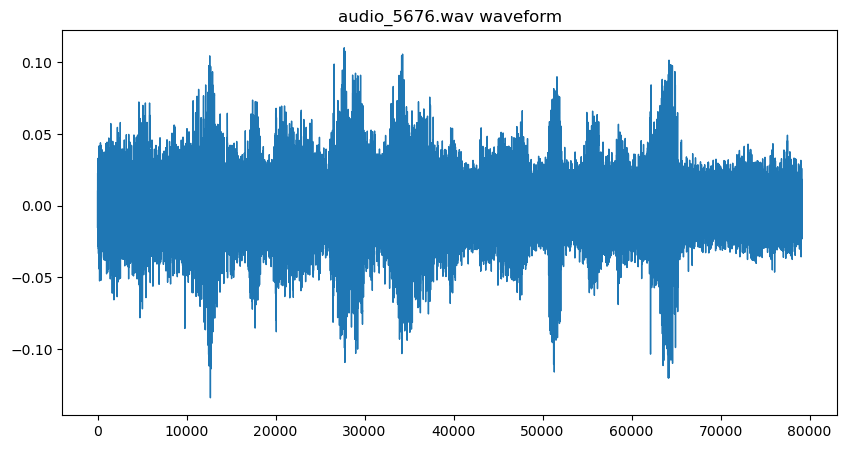

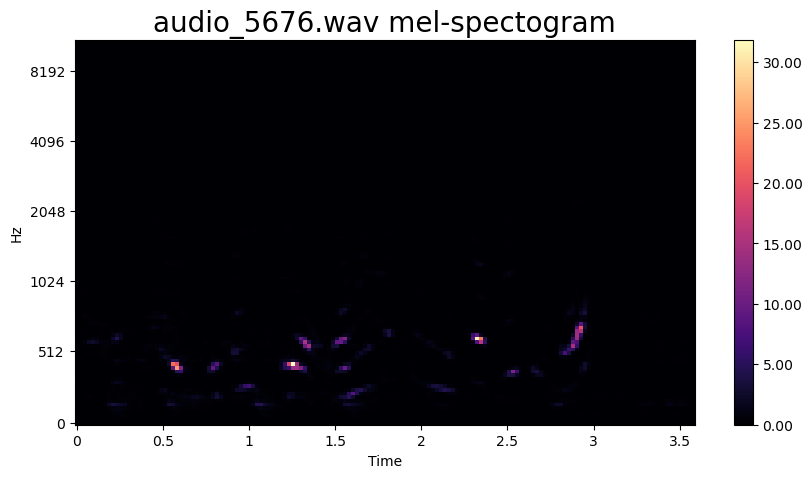

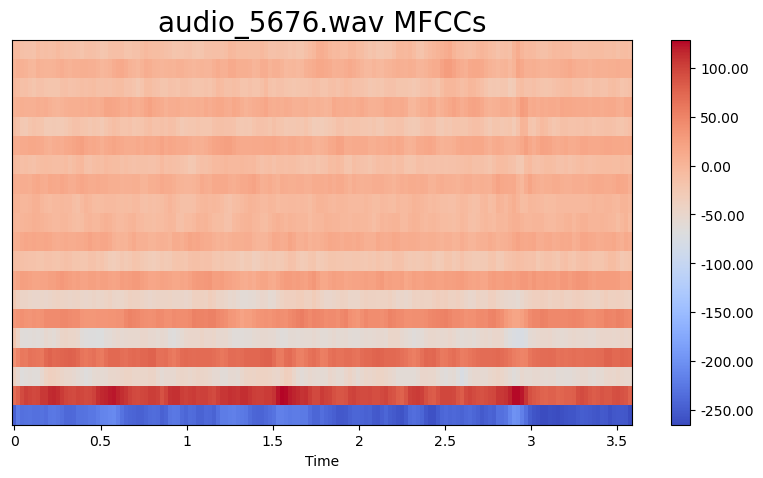

In [16]:
n = 1
examples = train_df.sample(n).reset_index()
for i in range(n):
    print(examples.loc[i]["text"])
    plot_audio(examples.loc[i])

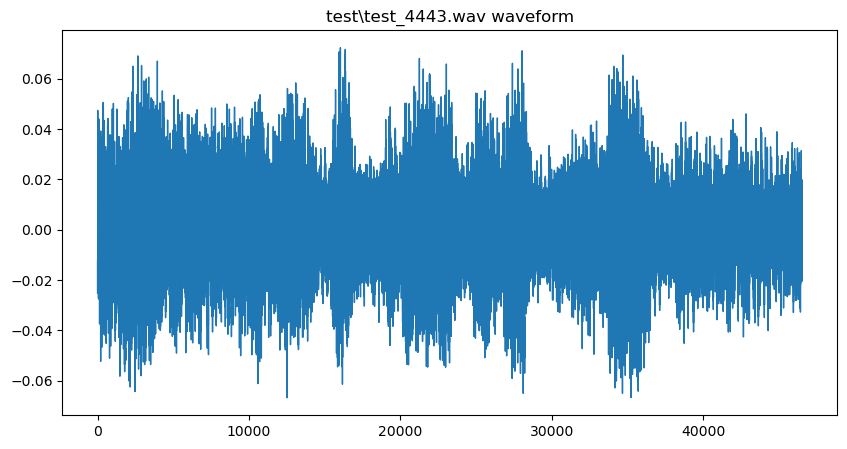

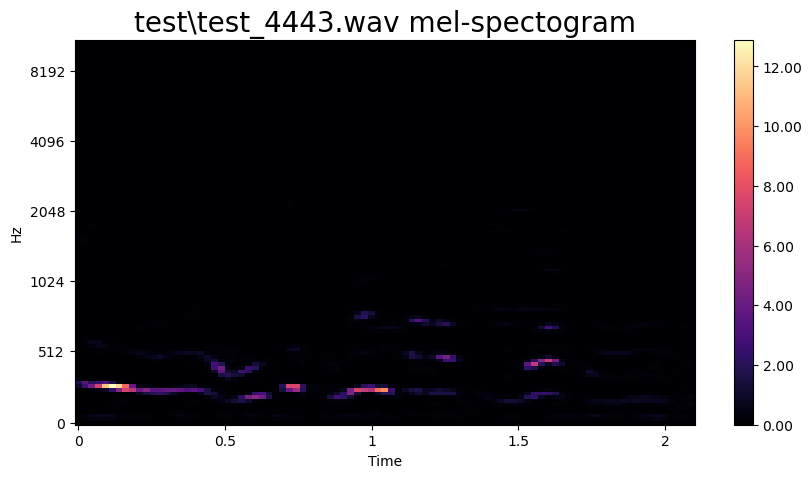

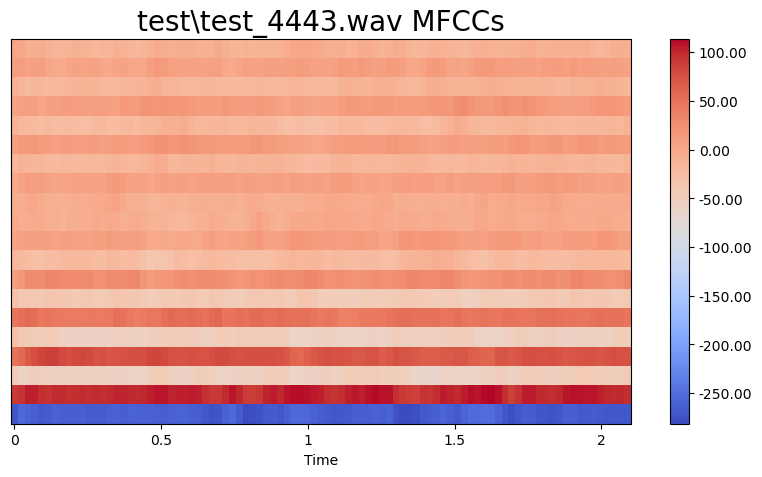

In [17]:
n = 1
examples = test_df.sample(n).reset_index()
for i in range(n):
    plot_audio(examples.loc[i])

In [20]:
print(f"train data total length = {train_df['audio_length'].sum() / 60 / 60} hour")
print(f"test data total length = {test_df['audio_length'].sum() / 60 / 60} hour")

train data total length = 16.385990511424477 hour
test data total length = 7.053580922028533 hour


In [21]:
print(train_df["text"].value_counts())

text
매주 같은 시간에 알림을 울려 주시오.                                                                                                                                             9
호텔에서 서울역까지 가는 데 몇 분 걸리니?                                                                                                                                          9
병원에 돈 내는 곳 좀 찾아 줄래?                                                                                                                                               8
신나는 노래방 있으면 알려 주세요.                                                                                                                                               8
어제 들었던 콩쥐팥쥐 다시 들려 드릴까요?                                                                                                                                           8
                                                                                                                                                                 ..
드레싱이란 상처를 지

In [32]:
print(train_df[train_df["audio_length"] > 7.5]["text"].value_counts())

text
저는 어떤 극소수의 융통성이 필요한 상황에서는 규칙을 어길 수 있다고 생각합니다. 하지만 그것이 극 소수인 만큼 굉장히 신중을 기해야 한다는 점 먼저 말씀드리고 싶습니다. 회사는 어쨌든 이익을 만들어내기 위한 단체입니다. 그렇기 때문에 회사에서 규칙을 어겼을 때 이익을 얻을 수 있는지 손익 계산이 가장 중요하다고 생각합니다. 하지만 융통성으로 인해서 어떤 이익을 얻을 수 있는 상황이라고 하더라도 저는 규칙을 어기지 말라고 당부드리고 싶습니다. 이 규칙을 어김으로 인해서 당장의 이익은 얻을 수 있겠지만 나중에 다가올 어떤 부작용의 후폭풍을 저는 조금 더 데미지가 크다고 생각하기 때문에 저는 절대 규칙을 어기지 않는 사람이 되겠습니다.    1
간호조무사가 할 수 있는 방법으로는 제가 생각하였을 때는 위로와 독려 그리고 기본 간호 의료 서비스를 제공한다입니다. 저희 병동에서 젊으신 분이 암과 질병으로 인하여 입원하였던 분이 계셨는데 걱정이 많으셨었던 그런 과정에서 제가 위로의 말을 도와드리고 기본적인 의료 보조 서비스를 제공해드렸습니다. 환자분께서 저의 의료 서비스 제공을 받으신 후 저에 대한 칭찬 카드를 작성하였던 기억이 있습니다. 온전히 모든 것을 치유하는 데에 도움을 드릴 수는 없지만 심리적인 안정을 위해서 간호조무사도 간호서비스와 기본적인 의료 서비스를 제공할 수 있다고                                                          1
제 자신에게 가장 큰 영향을 끼친 사람은 아버지입니다. 아버지의 삶을 보면서 어떻게 살아가야 하고 그리고 또 어떤 부분이 본받아야 되며 어떤 부분은 하지 말아야 할 것을 알게 되었습니다. 또한 아버지나 저희 어머니께서 주신 그 무한한 사랑 때문에 사람을 대하거나 할 때 단순히 내게 유익이 있는 것만을 찾는 것이 아니라 유익이 없더라도 사람을 사랑하고 좋아할 수 있는 법에 대해 알게 되었습니다.                                                